# CNN GE Exploration
**Date: 11/19/2020**

### Resources/Guides
- https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/
- https://github.com/youngsoul/pyimagesearch-regression-with-keras
- https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
- https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting

In [ ]:
# imports
import pandas as pd
import copy 
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import glob
import cv2
import os
from PIL import Image
import glob
from os import listdir
from os.path import isfile, join
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----------------------------------------------------------------------------------------------------

## Functions

In [ ]:
def create_mlp(dim, regress=False):
    """
    create a multi-layer perceptron architeture with: dim-8-4
    :param dim:
    :param regress:
    :return:
    """
    #define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation='relu'))
    model.add(Dense(4, activation='relu'))

    # check to see if the regression node should be added
    # If we are performing regression, we add a Dense layer containing a
    # single neuron with a linear activation function (below).
    # Typically we use ReLU-based activations, but since we are performing
    # regression we need a linear activation.
    if regress:
        model.add(Dense(1, activation="linear"))

    return model

In [ ]:
def create_cnn(width, height, depth, filters=(16,32,64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # flatten the volume, then FC => RELU => BN => DROPOUT
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)

        # apply another FC layer, this one to match the number of nodes
        # coming out of the MLP
        x = Dense(4)(x)
        x = Activation("relu")(x)

        # check to see if the regression node should be added
        if regress:
            x = Dense(1, activation="linear")(x)

        # construct the CNN
        model = Model(inputs, x)

        # return the CNN
        return model

In [ ]:
# this has not been changed and can include the data cleaning portion.
def process_house_attributes(df, train, test):
    
    # initialize the column names of the continous data
    continuous = ['bedrooms', 'bathrooms', 'area']

    # perform min-max scalling each continous feature column to the range [0,1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.fit_transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoding, all output features are now in the range [0, 1])
    # NOTE: we fit on the entirety of the dataset, then transform the training and test
    # because it is possible that the training and test might not have some of the total possible
    # zipcode values.
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    testCategorical = zipBinarizer.transform(test["zipcode"])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)

In [ ]:
def load_house_attributes(inputPath):
    """
    Read in the housing data.  The intial dataset contains 535 rows, but because some zipcodes only
    have a few houses, we are removing rows (houses) in a zipcode if there are less than 25 houses in
    a zipcode.  That will reduce our dataset to 362 rows (houses)
    :param inputPath:
    :return:
    """
    df = pd.read_csv(inputPath)
    return df

In [ ]:
def load_house_images(df, paths_list, path):
    """
    For each index, read the set of 4 images, and create a 4x4 montage of all separate images
    to create a single image for each house to train o.
    :param df:
    :param inputPath:
    :return:
    """
    # initialize our images array
    images = []

    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")
    for housePath in paths_list:
      image = cv2.imread( path +'/' + housePath)
      inputImages.append(image)

    images = inputImages # I changed the code here

    # return our set of images
    return np.array(images)

In [ ]:
def load_house_images(df, paths_list, path):
    """
    For each index, read the set of 4 images, and create a 4x4 montage of all separate images
    to create a single image for each house to train o.
    :param df:
    :param inputPath:
    :return:
    """
    # initialize our images array
    images = []
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")
    for housePath in paths_list:
      image = cv2.imread( path +'/' + housePath)
      inputImages.append(image)

    images = inputImages # I changed the code here

    # return our set of images
    return np.array(images)

----------------------------------------------------------------------------------------------------------------

In [ ]:
# path = '162_cnn_hassan.csv'
path_162 = "/content/drive/MyDrive/GE_data_x/GE_dataset/cnn_hassan/v1_cnn/162_cnn_hassan_v3.csv"
path_182 = '/content/drive/MyDrive/GE_data_x/GE_dataset/cnn_hassan/182_cnn_hassan_relevant_frames.csv'
width_162_df = pd.read_csv(path_162)
width_182_df = pd.read_csv(path_182)[['tdms_index', 'Width']].rename(columns={"tdms_index": "Frame_Index"})

In [ ]:
frames = [width_162_df, width_182_df]
# width_df = pd.concat(frames)
width_df = width_162_df
width_df.head(1)

,Frame_Index,Width
0,639002,127.088203


In [ ]:
index_vals = []
for elem in width_df['Frame_Index']: index_vals.append(elem)

In [ ]:
type(index_vals[0])

int

In [ ]:
def dirs_func(new_path):
  dirs = os.listdir(new_path)
  # This would print all the files and directories
  onlyfiles = []
  for file in dirs:
    onlyfiles.append(file)
  return onlyfiles

In [ ]:
# Open a file
new_path1 = "/content/drive/MyDrive/GE_data_x/frames_162_hassan"
onlyfiles1 = dirs_func(new_path1)

In [ ]:
# new_path2 = "/content/drive/MyDrive/GE_data_x/frames_182_png"
# onlyfiles2 = dirs_func(new_path2)

In [ ]:
onlyfiles = onlyfiles1 #+ onlyfiles2

In [ ]:
relevant_images, rel_vals = [], [] # we will join using relevant vals
for file_name in onlyfiles:
    try:
        try:
          int_val = int(file_name[6:12])
        except Exception: pass
        # try:
        #   int_val = int(file_name[14:20])
        # except Exception: pass
        if int_val in index_vals:
            relevant_images.append(file_name)
            rel_vals.append(int_val)
    except Exception: pass

In [ ]:
len(relevant_images)

13254

In [ ]:
num_pics = len(relevant_images)#int(len(relevant_images)*0.7) # this value can be changed.
image_name_list = []
for img_name in relevant_images[:num_pics]:
    try:
      for filename in glob.glob(new_path1 + '/' + str(img_name)):
          image_name_list.append(img_name)
    except Exception: pass
    # try:
    #   for filename in glob.glob(new_path2 + '/' + str(img_name)):
    #       image_name_list.append(img_name)
    except Exception: pass

In [ ]:
len(image_name_list)

13254

In [ ]:
# stut = relevant_images[-10:][0]
# hut = relevant_images[10:][0]
# print(stut)
# print(hut)

In [ ]:
# glob.glob(new_path1 + '/' + str(hut))
# image_name_list[0]

In [ ]:
# d = {'Frame_Index': rel_vals[:num_pics], 'image_pil': image_list[:num_pics], 'image_names.png': image_name_list}
d1 = {'Frame_Index': rel_vals[:num_pics], 'image_names.png': image_name_list}
df2 = pd.DataFrame(data=d1)

In [ ]:
# path is defined above
df = width_df

In [ ]:
# using deepcopy to deep copy
left = copy.deepcopy(df)
right = copy.deepcopy(df2)

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
result = pd.merge(left.reset_index(), right.reset_index(),on=['Frame_Index'], how='inner')

In [ ]:
result.head(3)
# NEXT STEPS
# - feed the image_names into the other function and try to get output

,index_x,Frame_Index,Width,index_y,image_names.png
0,0,639002,127.088203,13157,frame_639002.png
1,1,639003,127.088203,13158,frame_639003.png
2,2,639004,127.088203,13159,frame_639004.png


In [ ]:
len(result)

13254

In [ ]:
# first10 = result.head(10)
# last10 = result.tail(10)
# diverse_trial_df = pd.concat([first10, last10])

In [ ]:
curr_count = 0
for string in result['image_names.png']:
  if 'video' in string:
    curr_count+=1
print(curr_count)

0


In [ ]:
back_val = len(result) - curr_count

In [ ]:
back_end_df = result.tail(curr_count)
back_end_df

,index_x,Frame_Index,Width,index_y,image_names.png


In [ ]:
front_end_df = result.head(back_val)
front_end_df

,index_x,Frame_Index,Width,index_y,image_names.png
0,0,639002,127.088203,13157,frame_639002.png
1,1,639003,127.088203,13158,frame_639003.png
2,2,639004,127.088203,13159,frame_639004.png
3,3,639005,127.088203,13160,frame_639005.png
4,4,639006,127.088203,13161,frame_639006.png
...,...,...,...,...,...
13249,13249,659126,121.859528,584,frame_659126.png
13250,13250,659127,121.859528,585,frame_659127.png
13251,13251,659128,121.859528,586,frame_659128.png
13252,13252,659129,121.859528,587,frame_659129.png


---------------------------------------------------------------------------------------------------------------------

## Running the CNN

In [ ]:
# images = load_house_images(result, result['image_names.png'], new_path1, new_path2)

# updating this with diverse_trial_df instead of the result
first_images = load_house_images(result, result['image_names.png'], new_path1)
# last_images = load_house_images(back_end_df, back_end_df['image_names.png'], new_path2)

In [ ]:
# images = np.concatenate((first_images,last_images), axis=0)
images = first_images

In [ ]:
# len(images)
images.shape

In [ ]:
images = images / 255.0

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# images = datasets.load_house_images(df, args["dataset"])
# images = images / 255.0

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing

# split = train_test_split(diverse_trial_df, images, test_size=0.25, random_state=42) # added div trial to run faster
split = train_test_split(result, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

In [ ]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["Width"].max()
trainY = trainAttrX["Width"] / maxPrice
testY = testAttrX["Width"] / maxPrice

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
# from keras.optimizers import adam
from keras.optimizers import Adam
import keras.optimizers

In [ ]:
# create our Convolutional Neural Network and then compile the model
# using mean absolute percentage error as our loss, implying that we
# seek to minimize the absolute percentage difference between our
# price *predictions* and the *actual prices*
model = create_cnn(80, 80, 3, regress=True)
opt = keras.optimizers.Adam(lr=1e-4, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# this is to record data before it stops in case it crashes

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
new_path_checkpoint = "/content/drive/MyDrive/GE_data_x/GE_dataset\cnn_hassan\cnn_training"

checkpoint = ModelCheckpoint(new_path_checkpoint+'/'+'model{epoch:08d}.h5', period=5) 

# history = model.fit()

In [ ]:
# train the model
print("[INFO] training model...")

# next step would be to try with different epoch & batch size vals
# we can loom from 10-50 batch sizes along with 400-1200 epochs - 
# tbh once it converges there is no point in trying to keep running epochs.

# epochs=400, batch_size=16 - original
# epochs=1000, batch_size=25 - worse performance - mean: 551.21%, std: 296.24%

# epochs=1000, batch_size=25 - mean: 14.30%, std: 8.86% - num_images - 4000

# for all 162 images the performance was wose - not recorded

# epochs=1000, batch size= 25 mean: 15.12%, std: 18.61% - num images = 9100

# it looks like 7000 would be an ideal epochs? just a guess based on minimum val_loss

# look into the other parameters of model.fit
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY), epochs=1000, batch_size=25, callbacks=[checkpoint])

In [ ]:
# make predictions on the testing data
print("[INFO] predicting widths...")
preds = model.predict(testImagesX)

In [ ]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [ ]:
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# use RMSE/MAPE and show errors in a historgram

In [ ]:
# finally, show some statistics on our model
import locale
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. width: {}, std width: {}".format(
    result["Width"].mean(),
    result["Width"].std()))

# use RMSE/MAPE and show errors in a historgram
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

In [ ]:
diff

In [ ]:
testY

In [ ]:
new_preds = []
for pred in preds:
  v = pred[0]
  new_preds.append(v)

In [ ]:
rdff = {'Preds': new_preds, 'Preds Flatten':preds.flatten(), 'test Y': testY, 'diff': diff, 'percentDiff':percentDiff}
epochs_1000_batch_size_25_img_4000_df = pd.DataFrame(data=rdff)

In [ ]:
epochs_1000_batch_size_25_img_4000_df.head()

In [ ]:
epochs_1000_batch_size_25_img_4000_df.to_csv()

NameError: ignored

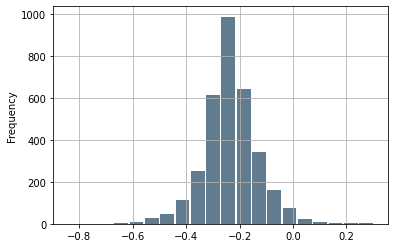

In [ ]:
percentDiff.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('percent Diff/Error')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)